# Install LLM, RAG dependencies

In [1]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

-------------------------


In [2]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.5/136.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.1/417.1 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 580.2/580.2 kB 19.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))
print(check_output(["ls", "../input/pokdex-for-all-1025-pokemon-w-text-description"]).decode("utf8"))

pokdex-for-all-1025-pokemon-w-text-description

pokedex.csv



In [4]:
import sys
import time
from typing import List, Dict, Text, Optional
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")

print("Python version: {}". format(sys.version))
print("NumPy version: {}". format(np.__version__))
print("pandas version: {}". format(pd.__version__))
print("matplotlib version: {}". format(matplotlib.__version__))

Python version: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
NumPy version: 1.26.4
pandas version: 2.2.3
matplotlib version: 3.7.5


# 1.0 Load data

In [5]:
DATA_FILE_PATH = "/kaggle/input/pokdex-for-all-1025-pokemon-w-text-description/pokedex.csv"

In [6]:
pokedex_df = pd.read_csv(DATA_FILE_PATH)

pokedex_df.head()

,id,name,height,weight,hp,attack,defense,s_attack,s_defense,speed,type,evo_set,info
0,1,bulbasaur,7,69,45,49,49,65,65,45,"{grass,poison}",1,A strange seed was planted on its back at birt...
1,2,ivysaur,10,130,60,62,63,80,80,60,"{grass,poison}",1,"When the bulb on its back grows large, it appe..."
2,3,venusaur,20,1000,80,82,83,100,100,80,"{grass,poison}",1,The plant blooms when it is absorbing solar en...
3,4,charmander,6,85,39,52,43,60,50,65,{fire},2,"Obviously prefers hot places. When it rains, s..."
4,5,charmeleon,11,190,58,64,58,80,65,80,{fire},2,"When it swings its burning tail, it elevates t..."


# 1.1 Describe data

In [7]:
# Getting Info
display(pokedex_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1025 non-null   int64 
 1   name       1025 non-null   object
 2   height     1025 non-null   int64 
 3   weight     1025 non-null   int64 
 4   hp         1025 non-null   int64 
 5   attack     1025 non-null   int64 
 6   defense    1025 non-null   int64 
 7   s_attack   1025 non-null   int64 
 8   s_defense  1025 non-null   int64 
 9   speed      1025 non-null   int64 
 10  type       1025 non-null   object
 11  evo_set    1025 non-null   int64 
 12  info       1025 non-null   object
dtypes: int64(10), object(3)
memory usage: 104.2+ KB


None

In [8]:
pokedex_df.describe()

,id,height,weight,hp,attack,defense,s_attack,s_defense,speed,evo_set
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,513.000000,12.116098,669.865366,70.184390,77.521951,72.507317,70.080976,70.205854,67.186341,253.195122
std,296.036315,12.481673,1212.731138,26.631054,29.782541,29.286972,29.658378,26.639329,28.717227,159.505305
min,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.000000
25%,257.000000,5.000000,85.000000,50.000000,55.000000,50.000000,47.000000,50.000000,45.000000,110.000000
50%,513.000000,10.000000,280.000000,68.000000,75.000000,70.000000,65.000000,67.000000,65.000000,257.000000
75%,769.000000,15.000000,700.000000,85.000000,100.000000,90.000000,90.000000,86.000000,88.000000,387.000000
max,1025.000000,200.000000,9999.000000,255.000000,181.000000,230.000000,173.000000,230.000000,200.000000,549.000000


## Null values

In [9]:
# Checking NULL values
display(pokedex_df.isnull().sum())

id           0
name         0
height       0
weight       0
hp           0
attack       0
defense      0
s_attack     0
s_defense    0
speed        0
type         0
evo_set      0
info         0
dtype: int64

# 1.2 EDA
## 1.2.1 Distribution of Height

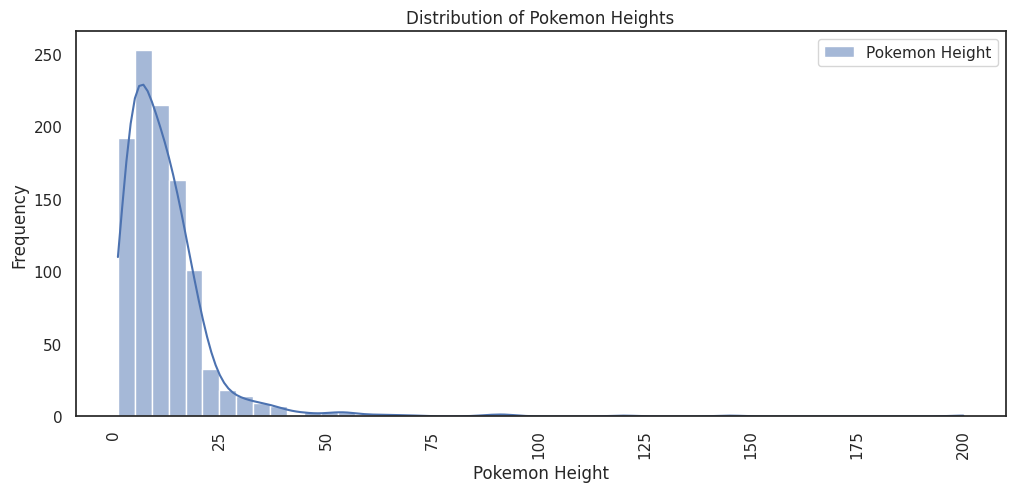

In [10]:
# Plot: Distribution of Pokemon Height
plt.figure(figsize=(12, 5))
sns.histplot(pokedex_df['height'], bins=50, kde=True, label='Pokemon Height')
plt.xlabel("Pokemon Height")
plt.ylabel("Frequency")
plt.title("Distribution of Pokemon Heights")
plt.xticks(rotation=90)
plt.legend()
plt.show()

## 1.2.2 Distribution of Weight

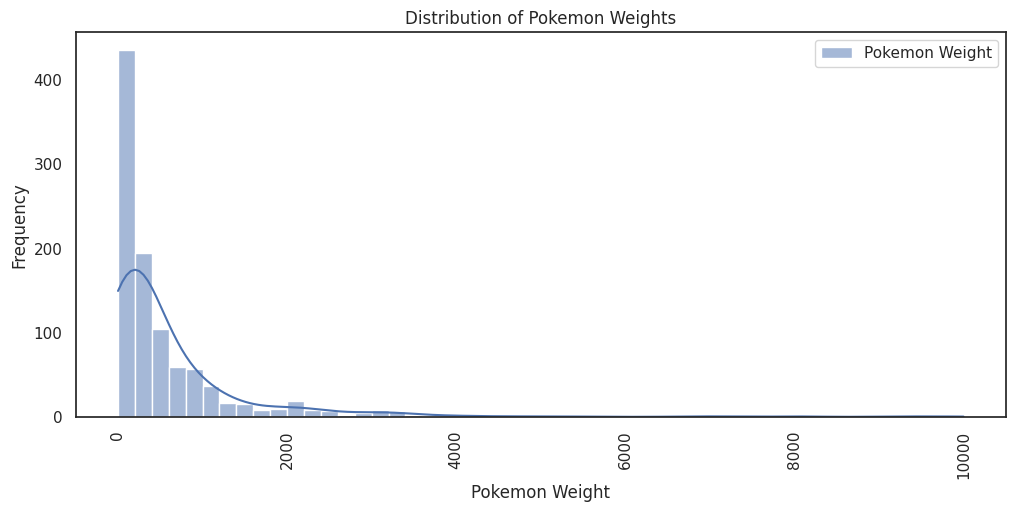

In [11]:
# Plot: Distribution of Pokemon Weight
plt.figure(figsize=(12, 5))
sns.histplot(pokedex_df['weight'], bins=50, kde=True, label='Pokemon Weight')
plt.xlabel("Pokemon Weight")
plt.ylabel("Frequency")
plt.title("Distribution of Pokemon Weights")
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [12]:
info = """
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1025 non-null   int64 
 1   name       1025 non-null   object
 2   height     1025 non-null   int64 
 3   weight     1025 non-null   int64 
 4   hp         1025 non-null   int64 
 5   attack     1025 non-null   int64 
 6   defense    1025 non-null   int64 
 7   s_attack   1025 non-null   int64 
 8   s_defense  1025 non-null   int64 
 9   speed      1025 non-null   int64 
 10  type       1025 non-null   object
 11  evo_set    1025 non-null   int64 
 12  info       1025 non-null   object
"""
numerical_columns = [
    line.strip().split()[1] for line in info.split("\n") 
    if line != '' and line.strip().split()[-1] in ['int64', 'float64']
]
print(numerical_columns)

['id', 'height', 'weight', 'hp', 'attack', 'defense', 's_attack', 's_defense', 'speed', 'evo_set']


## 1.2.3 Correlation between features

<Axes: >

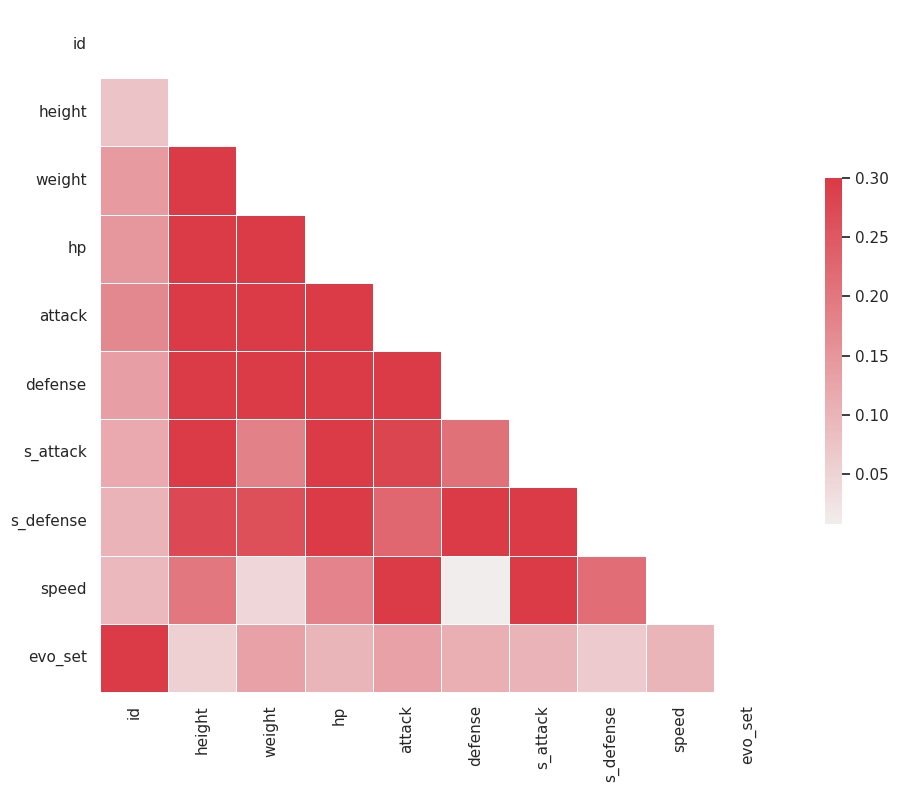

In [13]:
# Correlation matrix
corr = pokedex_df[numerical_columns].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# 2.0 Retrieval Augmented Generation
## 2.0.0 Imports

In [14]:
import os
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

os.environ["OPENAI_API_KEY"] = user_secrets.get_secret("OPENAI_API_KEY")
OPENAI_API_KEY = user_secrets.get_secret("OPENAI_API_KEY")

In [15]:
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import CSVLoader
from langchain_core.vectorstores import InMemoryVectorStore

## 2.0.1 Initialize LLM and Embeddings

In [16]:
llm = init_chat_model("gpt-4o-mini", model_provider="openai")

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

## 2.0.2 Load CSV data as documents using LangChain

In [17]:
loader = CSVLoader(file_path=DATA_FILE_PATH)
data = loader.load()

for record in data[:2]:
    print(record)

page_content='id: 1
name: bulbasaur
height: 7
weight: 69
hp: 45
attack: 49
defense: 49
s_attack: 65
s_defense: 65
speed: 45
type: {grass,poison}
evo_set: 1
info: A strange seed was planted on its back at birth. The plant sprouts and grows with this POKéMON.' metadata={'source': '/kaggle/input/pokdex-for-all-1025-pokemon-w-text-description/pokedex.csv', 'row': 0}
page_content='id: 2
name: ivysaur
height: 10
weight: 130
hp: 60
attack: 62
defense: 63
s_attack: 80
s_defense: 80
speed: 60
type: {grass,poison}
evo_set: 1
info: When the bulb on its back grows large, it appears to lose the ability to stand on its hind legs.' metadata={'source': '/kaggle/input/pokdex-for-all-1025-pokemon-w-text-description/pokedex.csv', 'row': 1}


## 2.0.3 Store documents for search

In [18]:
vector_store = InMemoryVectorStore.from_documents(data, embeddings)

In [19]:
docs = vector_store.similarity_search("Tell me about Pikachu", k=2)
for doc in docs:
    print(doc)

page_content='id: 25
name: pikachu
height: 4
weight: 60
hp: 35
attack: 55
defense: 40
s_attack: 50
s_defense: 50
speed: 90
type: {electric}
evo_set: 10
info: When several of these POKéMON gather, their electricity could build and cause lightning storms.' metadata={'source': '/kaggle/input/pokdex-for-all-1025-pokemon-w-text-description/pokedex.csv', 'row': 24}
page_content='id: 172
name: pichu
height: 3
weight: 20
hp: 20
attack: 40
defense: 15
s_attack: 35
s_defense: 35
speed: 60
type: {electric}
evo_set: 10
info: It is not yet skilled at storing electricity. It may send out a jolt if amused or startled.' metadata={'source': '/kaggle/input/pokdex-for-all-1025-pokemon-w-text-description/pokedex.csv', 'row': 171}


# 2.1 Generate RAG prompt with context

In [20]:
from pydantic import BaseModel
from typing import List, Dict, Optional

from langchain import hub

prompt = hub.pull("rlm/rag-prompt")


class State(BaseModel):
    question: str
    context: Optional[List[Dict]]
    answer: str


def retrieve(db, state: State):
    retrieved_docs = db.similarity_search(state["question"]) # defaults to k = 4, so max 4 documents are returned.
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke(
        {"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


def retrieve_and_generate(user_prompt, tenant=None):
    state = {'question': user_prompt, 'context': None, 'answer': ''}
    if tenant:
        state.update({'tenant': tenant})

    context = retrieve(vector_store, state)
    state['context'] = context['context']
    
    ans = generate(state)['answer']
    return ans


def print_rag(user_prompt, rag_answer):
    print("Question: \t{}".format(user_prompt))
    print("Answer: \t{}".format(rag_answer))

In [21]:
state = {'question': "The Pokemon which controls space", 'context': None, 'answer': ''}

context = retrieve(vector_store, state)
state['context'] = context['context']

print(generate(state)['answer'])

The Pokémon that controls space is Palkia. It is described as having the ability to distort space and is considered a deity in Sinnoh-region mythology.


# 2.2 Ask Questions
## Questions about my favorites: Dialga & Palkia from Sinnoh Region

In [22]:
ques = "Which Pokemon have the ability to manipulate space?"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

print()
pkmn = pokedex_df[pokedex_df.name.isin(['palkia'])]
print("Pokemon:", pkmn['name'].tolist()[0].title(), "\nInfo:", pkmn['info'].tolist()[0])

Question: 	Which Pokemon have the ability to manipulate space?
Answer: 	The Pokémon that have the ability to manipulate space are Palkia, which can distort space, and Hoopa, which can warp space using its loop. Deoxys is also associated with space due to its origin from a space virus, but it does not specifically manipulate space like the others.

Pokemon: Palkia 
Info: It has the ability to distort space. It is described as a deity in Sinnoh-region mythology.


In [23]:
ques = "Which Pokemon have the ability to control time?"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

print()
pkmn = pokedex_df[pokedex_df.name.isin(['dialga'])]
print("Pokemon:", pkmn['name'].tolist()[0].title(), "\nInfo:", pkmn['info'].tolist()[0])

Question: 	Which Pokemon have the ability to control time?
Answer: 	The Pokémon that have the ability to control time are Dialga and Celebi. Dialga is known for its power to control time, while Celebi is described as wandering across time.

Pokemon: Dialga 
Info: It has the power to control time. It appears in Sinnoh-region myths as an ancient deity.


In [24]:
ques = "Popular ghost pokemon"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 	Popular ghost pokemon
Answer: 	Popular ghost Pokémon include Gastly, Phantump, and Lampent. Gastly is known for its ability to cloak targets and put them to sleep, while Phantump is created when spirits possess tree stumps. Lampent wanders cities looking for the spirits of the fallen.


In [25]:
ques = "Can you tell me about Pokemon which are from folk tales?"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 	Can you tell me about Pokemon which are from folk tales?
Answer: 	Pokémon like Giratina and Gothorita are inspired by folk tales. Giratina is said to inhabit a world on the reverse side of ours, linked to ancient legends, while Gothorita is known for using hypnosis to mislead people, reflecting stories found in various cultures. Relicanth, while an ancient species, does not specifically relate to folk tales in the same way.


In [26]:
ques = "Pokemon which cause Forest fires"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

print()
pkmn = pokedex_df[pokedex_df.name.isin(['charizard'])]
print("Pokemon:", pkmn['name'].tolist()[0].title(), "\nInfo:", pkmn['info'].tolist()[0])

Question: 	Pokemon which cause Forest fires
Answer: 	Pokémon that can cause forest fires include Charizard, which can spit fire hot enough to melt boulders and is known to cause forest fires unintentionally. Torchic and Pignite also have fire-related abilities, though they are not specifically noted for causing fires in forests.

Pokemon: Charizard 
Info: Spits fire that is hot enough to melt boulders. Known to cause forest fires unintentionally.


## Where RAG works well and prevents inaccurate information from being provided to the user

In [27]:
ques = "Microsoft Office"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 	Microsoft Office
Answer: 	I don't know.


In [28]:
ques = "Nani"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 	Nani
Answer: 	I don't know.


In [29]:
ques = "Classical Music"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 	Classical Music
Answer: 	The retrieved context mentions various Pokémon with musical abilities, highlighting their connection to classical themes. Meloetta can control emotions through its special melodies, while Primarina learns and passes down songs generationally. Ludicolo responds to festive music, dancing along to it, indicating a strong link between music and their behavior.


In [30]:
ques = "Which Pokemon can dance Salsa?"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 	Which Pokemon can dance Salsa?
Answer: 	Ludicolo is known to begin dancing as soon as it hears cheerful, festive music, making it a suitable candidate for salsa dancing. Maractus also uses dance to drive away predators, but specifically for up-tempo songs. Therefore, Ludicolo is the primary Pokémon associated with dance in this context.


In [31]:
ques = "Create a trivia question and answer pair on Pikachu"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

print()
pikachu = pokedex_df[pokedex_df.name.isin(['pikachu'])]
print("Pokemon:", pikachu['name'].tolist()[0].title(), "\nInfo:", pikachu['info'].tolist()[0])

Question: 	Create a trivia question and answer pair on Pikachu
Answer: 	Trivia Question: What type of Pokémon is Pikachu, and what phenomenon can occur when several of them gather?  
Answer: Pikachu is an Electric-type Pokémon, and when several of them gather, their electricity can build up and cause lightning storms.

Pokemon: Pikachu 
Info: When several of these POKéMON gather, their electricity could build and cause lightning storms.


## Learning Example
### Where RAG goes "wrong"

In [32]:
ques = "Pokemon which can compete in Kaggle competitions"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 	Pokemon which can compete in Kaggle competitions
Answer: 	The Pokémon that can compete in Kaggle competitions include Rapidash, Kyogre, Zygarde, and Wo-Chien. Each has unique stats and abilities that may give them competitive advantages. Their performance would depend on the specific Kaggle competition parameters and rules.


#### First of all, what does it mean for an output to be wrong / incorrect?
We should start by defining our scope, and what set/type of outputs is considered out of scope, and what are our policies to handle: 1. Queries which are out of scope, and 2. LLM outputs which are out of scope.

Let's look at the process:

#### Process
1. User prompt (out of our control)
2. Retrieve documents from our knowledge base. (Vector DB)
3. Prepare System prompt and add context, and user prompt.
4. LLM inference of constructed prompt.

For the question above, "Pokemon which can compete in Kaggle competitions", we might want to restrict the LLM from answering questions which are beyond the scope of our knowledge base. We might want to reduce its creativity in trying to generate an answer.

We can do this by:
- Checking the documents distance threshold and seeing if our query is beyond a certain distance from the documents. If yes, we might want to modify the system prompt (on the fly), or return more documents, or respond to the user without going through the LLM.
- Changing our system prompt to be more restrictive and/or providing more context about the world of Pokemon.

In [33]:
ques = "Tallest pokemon"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 	Tallest pokemon
Answer: 	The tallest Pokémon is Palkia, standing at 42 units tall.


### Debugging: Let's check if Palkia is the tallest
Clearly it is not. RAG will work well with text, but we need to do more if we want to make qualitative comparisons on quantities.

In [34]:
import copy

tmp_df = copy.deepcopy(pokedex_df)
tmp_df.sort_values(by=['height'], ascending=False, inplace=True)
display(tmp_df.head(10))

print()
pkmn = pokedex_df[pokedex_df.name.isin(['palkia'])]
display(pkmn[['id', 'name', 'height', 'weight','type','info']])

,id,name,height,weight,hp,attack,defense,s_attack,s_defense,speed,type,evo_set,info
889,890,eternatus,200,9500,140,85,95,145,95,130,"{poison,dragon}",469,The core on its chest absorbs energy emanating...
320,321,wailord,145,3980,170,90,45,90,45,60,{water},161,WAILORD is the largest of all identified POKéM...
976,977,dondozo,120,2200,150,100,115,65,65,35,{water},513,"This Pokémon is a glutton, but it’s bad at get..."
796,797,celesteela,92,9999,97,101,103,107,101,61,"{steel,flying}",418,It appeared from the Ultra Wormhole. Witnesses...
207,208,steelix,92,4000,75,85,200,55,65,30,"{steel,ground}",41,It is thought its body transformed as a result...
94,95,onix,88,2100,35,45,160,30,45,70,"{rock,ground}",41,"As it grows, the stone portions of its body ha..."
383,384,rayquaza,70,2065,105,150,90,150,90,95,"{dragon,flying}",200,RAYQUAZA lived for hundreds of millions of yea...
129,130,gyarados,65,2350,95,125,79,60,100,81,"{water,flying}",64,"Once it begins to rampage, a GYARADOS will bur..."
349,350,milotic,62,1620,95,60,79,100,125,81,{water},178,Its lovely scales are described as rainbow col...
716,717,yveltal,58,2030,126,131,95,131,98,99,"{dark,flying}",369,When this legendary Pokémon’s wings and tail f...


,id,name,height,weight,type,info
483,484,palkia,42,3360,"{water,dragon}",It has the ability to distort space. It is des...


### Why our system failed to answer the "tallest pokemon?" question
1. Structured Data: LLMs don't work well with structured data. Even if we provided all the documents i.e. all Pokemon's info, the LLM would still probably not be able to "figure out" the tallest Pokemon, because it is not performing any quantitative analysis.
2. Knowledge Base: The Vector DB returns only a limited number of documents. In my case, I'm using the default of 4.
3. LLM Knowledge: The documents returned may not have included the tallest Pokemon, and the LLM couldn't use the knowledge of the tallest Pokemon it obtained from the internet.

We can check each of these, and there will be more cause "vectors" which I may have missed.

#### 1. Structured Data
##### Challenge
LLMs don’t work well with structured data, and CSV dataset usually don't have information on what the fields' units are, and sometimes they (fields/columns) aren't named well.

##### Solution
Converting the numerical fields into text fields such as “Height Info” field having an English sentence saying “The height of Palkia is 42 decimeters”, would allow the LLM to better use that information.

Despite this, because the RAG only gives you information of the top X documents, the output may still be incorrect.

#### 2. Knowledge Base: Vector DB limit
##### Challenge
We retrieve 4 documents for each query.

Let’s say the word tallest, is present explicitly or implicitly in 20 documents out of 1000+ Pokemon, and out of these the 4 which are returned are not of the tallest Pokemon, but just Pokemon where height is mentioned in their Pokedex entry, the context itself may be completely incorrect.

##### Solution
One solution could be to add documents containing information about: 
- The tallest Pokemon.
- The shortest Pokemon.
- The Heaviest Pokemon.
- The Lightest Pokemon.
- etc.

Now, if we search for tallest Pokemon, it will return one document having information on the tallest Pokemon.

Another solution could be to have one document listing all the Pokemon and their heights in order from tallest to shortest. This way, reasoning models could even possibly tell you the rank of the Pokemon's height.

Using one of these solutions, we can answer all those questions. Here the problem is the lack of required text based information in the knowledge base.

#### 3. LLM knowledge: LLM knowledge and RAG document lack of overlap
When I provide GPT 4o-mini the prompt "tallest pokemon" without going through the RAG process, it returns this:
> As of my last knowledge update in October 2023, the tallest Pokémon is Mega Rayquaza, which stands at 10 feet (3.05 meters) tall. It's worth noting that while Rayquaza is known for its height in its Mega form, other Pokémon like Wailord and Giratin in their different forms also have significant heights but don't surpass Mega Rayquaza.
>
> If you have any specific questions or need more information about Pokémon, feel free to ask!

Let's check the documents returned by "tallest pokemon", and see if the documents have Rayquaza or Mega Rayquaza.

In [35]:
def print_retrieved_documents(db, user_prompt: Text, relevant_document_fields: Optional[List[Text]]=None):
    state = {'question': user_prompt, 'context': None, 'answer': ''}
    result = retrieve(db, state)
    docs = []
    for doc in result['context']:
        if relevant_document_fields:
            pokemon_name = doc.page_content.split("\n")[1].rsplit(" ")[1]
            pkmn = pokedex_df[pokedex_df.name.isin([pokemon_name])]
            row = pkmn[relevant_document_fields].to_records()[0]
            docs.append(row)
        else:
            print(doc)
    if relevant_document_fields:
        tmp_df = pd.DataFrame.from_records(docs)
        tmp_df.columns = ['id'] + relevant_document_fields
        with pd.option_context('display.max_colwidth', None):
          display(tmp_df)

In [36]:
print_retrieved_documents(vector_store, "Tallest pokemon", ['name', 'height', 'type', 'info'])

,id,name,height,type,info
0,144,zapdos,16,"{electric,flying}",A legendary bird POKéMON that is said to appear from clouds while dropping enormous lightning bolts.
1,563,tirtouga,7,"{water,rock}","Restored from a fossil, this Pokémon can dive to depths beyond half a mile."
2,776,togedemaru,3,"{electric,steel}","The spiny fur on its back is normally at rest. When this Pokémon becomes agitated, its fur stands on end and stabs into its attackers."
3,483,palkia,42,"{water,dragon}",It has the ability to distort space. It is described as a deity in Sinnoh-region mythology.


We can see that our LLM did VERY well, given the context. Our user prompt = "tallest pokemon" returns 4 documents, for Zapdos, Tirtouga, Togedemaru, and Palkia.

"Pokemon" matched in the first three documents.

Looks like "tallest" was semantically similar to "enormous" (in the case of Zapdos), "half a mile" and "depths" (for Tirtouga), probably "stands on end" for Togedemaru.

Among these documents, Palkia has the largest value of Height.

The LLM did well and said Palkia is the tallest!

### Experiment: Adding Numerical Data as Text
Let's add some of the numerical data as text and see how our RAG performs.

In a real-world situation, we would create a bunch of these documents from the numerical values, so that our RAG works well.

Remember, given that LLMs are suffiently advanced nowadays, people will start to fall for the fallacy of "Argument from Authority" or "Appeal to Authority".

Treating everything that the LLM answers with as gospel. We may not be there yet, but we soon will be. Our RAG systems will need to become better able to handle edge cases to prevent potential issues, and our pipelines should be able to learn quickly from existing and new issues.

#### Let's start with Height

In [37]:
tallest_df = copy.deepcopy(pokedex_df)
tallest_df.sort_values(by=['height'], ascending=False, inplace=True)
display(tallest_df.head(3))

tallest_pokemon = tallest_df[['name', 'height', 'type', 'info']][:10].to_records()

tallest_doc = "The top 10 tallest Pokemon are {} in that order.".format(", ".join([r[1] for r in tallest_pokemon]))
print(tallest_doc)

,id,name,height,weight,hp,attack,defense,s_attack,s_defense,speed,type,evo_set,info
889,890,eternatus,200,9500,140,85,95,145,95,130,"{poison,dragon}",469,The core on its chest absorbs energy emanating...
320,321,wailord,145,3980,170,90,45,90,45,60,{water},161,WAILORD is the largest of all identified POKéM...
976,977,dondozo,120,2200,150,100,115,65,65,35,{water},513,"This Pokémon is a glutton, but it’s bad at get..."


The top 10 tallest Pokemon are eternatus, wailord, dondozo, celesteela, steelix, onix, rayquaza, gyarados, milotic, yveltal in that order.


Now let's add that text as a document to the Knowledge base.

In [38]:
vector_store.add_texts([tallest_doc])

['821a6987-8c29-482f-8c7a-a336611f26ec']

Re-test of "tallest pokemon" query.

In [39]:
ques = "Tallest pokemon"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 	Tallest pokemon
Answer: 	The tallest Pokémon is Eternatus. It ranks first in height among Pokémon. Other tall Pokémon include Wailord and Dondozo.


Wohoo!!

## "Grey" Area of RAG outputs
We need to figure out what responses and which inputs are acceptable.

If we were running an org, we would have policies in place for every situation and case, and a feedback loop from users which helps us identify problematic outputs and address them.

In [40]:
ques = "Pokemon which can use Excel and ChatGPT"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

print()
pkmn = pokedex_df[pokedex_df.name.isin(['porygon'])]
print("Pokemon:", pkmn['name'].tolist()[0].title(), "\nInfo:", pkmn['info'].tolist()[0])

Question: 	Pokemon which can use Excel and ChatGPT
Answer: 	The Pokémon that can be associated with using Excel and ChatGPT is Porygon, as it consists entirely of programming code and can move freely in cyberspace. Chatot can learn and speak human words, which aligns with interactive communication like ChatGPT. Magearna, being an artificial Pokémon that can understand human speech, adds to this theme as well.

Pokemon: Porygon 
Info: A POKéMON that consists entirely of programming code. Capable of moving freely in cyberspace.


In [41]:
ques = "Can Pokemon give ML interviews, and if not why?"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 	Can Pokemon give ML interviews, and if not why?
Answer: 	Pokémon cannot give machine learning interviews because they are fictional characters and do not possess the ability to communicate like humans. While some Pokémon can understand human speech, they cannot articulate thoughts or ideas effectively. Thus, they are not capable of participating in interviews.


In [42]:
ques = "Can Pokemon give ML interviews, and if yes why?"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 	Can Pokemon give ML interviews, and if yes why?
Answer: 	Pokémon cannot give ML interviews as they are fictional characters and do not possess the capability to participate in real-world events like interviews. While some Pokémon, like Magearna and Lucario, can understand human speech, they do not have the ability to communicate in human terms or engage in professional settings. Thus, it is not feasible for them to conduct interviews.


In [43]:
ques = "This dataset doesn't have any information that Pokemon are fictional. How did you come to that conclusion?"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 	This dataset doesn't have any information that Pokemon are fictional. How did you come to that conclusion?
Answer: 	The dataset provides detailed statistics and lore for various Pokémon without explicitly stating that they are fictional. However, the context implies that Pokémon, like Giratina and Magearna, possess fantastical traits and origins that suggest they are not real creatures. Thus, the conclusion that Pokémon are fictional is inferred from their described attributes and characteristics.


# 3.0 Conclusion
As we can see, RAG can perform fairly well, even with limited information. The better the LLM model doing the inference / reasoning, the better the output of the RAG.

Let's say this dataset contained more information about the each Pokemon, especially in text form, we could use that information to make our RAG better. We could also transform some quantitative values into categorical value with a meaningful text label, which can be used by the LLM to generate better responses. For example, we could add information about each Pokemon type (Ghost, Normal, Fire etc), and use that to query our data in a more granular fashion.

These common questions can be answered correctly with RAG, without random noise in training data of the LLM or things such as memes affecting the output of the LLM.